In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
widthStripesAmount=48
heightStripesAmount=64


In [2]:

class ImageManager:
    """datatype: generatedUnnoised or generatedNoised or real"""
    def __init__(self, dataType):
        self.__cloud_path_prefix = "/content/drive/My Drive/"
        #########___Data PATH___##############
        #FOR LOCAL DATA:
        #--REAL DATA:
        self._localDataset_metadata = "../data/raw/1channel/reference/epsilon.csv"
        self._localData_root_dir = "../data/raw/1channel/photo/"
        #--REAL DATA Filtered:
        self._localDataset_metadata_filtered = "../data/raw/1channel/reference/epsilon.csv"
        self._localData_root_dir_filtered = "../data/raw/1channel/medianedPhoto/"
        #--SELF-GENERATED DATA:
        #----UNNOISED
        self._localData_metadata_generated_unnoised = "../data/generated/unnoised/reference/epsilon.csv"
        self._localData_root_dir_generated_unnoised = "../data/generated/unnoised/photo/"
        #----NOISED
        self._localData_metadata_generated_noised = "../data/generated/noised/reference/epsilon.csv"
        self._localData_root_dir_generated_noised = "../data/generated/noised/photo/"
        #--MIXED-DATA:
        self._localData_metadata_generated_mixed = "../data/mixed/reference/epsilon.csv"
        self._localData_root_dir_generated_mixed = "../data/mixed/photo/"
        #--MIXED-Filtered:
        self._localData_metadata_generated_mixed_filtered = "../data/mixed/reference/epsilon.csv"
        self._localData_root_dir_generated_mixed_filtered = "../data/mixed/medianedPhoto/"

        #ON DRIVE:
        #--REAL DATA:
        self._cloudDataset_metadata = self.__cloud_path_prefix + "data/reference/real/epsilon_short.csv"
        self._cloudData_root_dir = self.__cloud_path_prefix + "data/photo/real/"
        #--SELF-GENERATED DATA:
        #----UNNOISED
        self._cloudData_metadata_generated_unnoised = self.__cloud_path_prefix + "data/reference/generated/unnoised/epsilon.csv"
        self._cloudData_root_dir_generated_unnoised = self.__cloud_path_prefix + "data/photo/generated/unnoised/"
        #----NOISED
        self._cloudData_metadata_generated_noised = self.__cloud_path_prefix + "data/reference/generated/noised/epsilon.csv"
        self._cloudData_root_dir_generated_noised = self.__cloud_path_prefix + "data/photo/generated/noised/"

        if(dataType=="generatedUnnoised"):
            self.root_dir=self._localData_root_dir_generated_unnoised
            self.annotation_file=self._localData_metadata_generated_unnoised
        elif(dataType=="generatedNoised"):
            self.root_dir=self._localData_root_dir_generated_noised
            self.annotation_file=self._localData_metadata_generated_noised
        elif(dataType=="real"):
            self.root_dir=self._localData_root_dir
            self.annotation_file=self._localDataset_metadata
        
        self.root_dir = self.root_dir
        self.annotations = pd.read_csv(self.annotation_file,skiprows=0, delim_whitespace=' ')

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        path=os.path.join(self.root_dir, str(str("%05d" %self.annotations.imgnr[index]))+ ".png")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        epsRead = self.annotations.eps[index]
        return img, epsRead

    


In [7]:
def CalculateStripMiddle(stripe, stripewidth):
    diagnose=0
    if(diagnose==1): print("CalculateStripMiddle")
    imgResized=cv2.resize(stripe, (int(stripewidth/4), 1),  interpolation = cv2.INTER_AREA)[0,:]
    if(diagnose==1):
        img=cv2.resize(stripe, (int(stripewidth), 1),  interpolation = cv2.INTER_AREA)[0,:]
        plt.plot(img)
        plt.show()
    middleWidth=stripewidth/2  #Niewiadomo, dlatego centralnie środek
    maxims=[]
    windowWidthEdge=3
    windowWidthMiddle=12
    for i in range (windowWidthMiddle, imgResized.shape[0]-windowWidthMiddle-1, 1):
        windowWidth=round(max(windowWidthMiddle-abs((middleWidth-i)/middleWidth*(windowWidthMiddle-windowWidthEdge)),windowWidthEdge))
        #print(windowWidth)
        if(imgResized[i]==max(imgResized[i-windowWidth:i+windowWidth])):
            if(len(maxims)>0 and int((maxims[-1]+windowWidth))<i*4):
                maxims.append(i*4)
            elif(len(maxims)==0):
                maxims.append(i*4)
            elif(int((maxims[-1]+windowWidth))>i*4):
                maxims[-1]=(maxims[-1]+i*4)/2

    maxims=np.array(maxims)
    diffs=np.diff(maxims)
    ind=np.argpartition(diffs,-2)[-2:]
    if(diagnose==1):
        print("maxims", maxims)
        print("diffs", diffs)
        print("ind", ind)
    #[10, 30, 100, 120, 190, 210]
    #[20, 70, 20, 70, 20]
    #[10, 30, 40, 180, 200, 210]
    #[20, 10, 120, 20, 10]
    
    StripMiddle=0
    if(abs(ind[0]-ind[1])==1):
        #ind=np.argpartition(diffs,-1)[-1:]
        #StripMiddle=(maxims[ind[0]]+maxims[ind[0]+1])/2
        StripMiddle=(maxims[min(ind)]+maxims[max(ind)+1])/2
    else:
        StripMiddle=(maxims[min(ind)+1]+maxims[max(ind)])/2
    if(diagnose==1):
        print("StripMiddle", StripMiddle)
    #if(ind[0]>ind[1]): ind[0]+=1                        ############ToCheck
    #else: ind[1]+=1                                     ############ToCheck
    
    #ind[0]+=1
    #ind[1]+=1
    #StripMiddle=int(np.mean(maxims[ind]))
    return int(StripMiddle)

def WidthMiddleFind(img, stripesAmount):
    height, width=img.shape
    stripesMeans=[]
    for i in range (0, height-int(height/stripesAmount), int(height/stripesAmount)):
        stripe=img[i: i+int(height/stripesAmount), : ]
        #print(CalculateStripMiddle(stripe))
        oneStripeMean=CalculateStripMiddle(stripe, width)
        stripesMeans.append(oneStripeMean)
    widthMiddle=int(np.round(np.mean(stripesMeans)))
    return widthMiddle

def WidthHeighFind(img, stripesAmount):
    height, width=img.shape
    stripesMeans=[]
    for i in range (0, width-int(width/stripesAmount), int(width/stripesAmount)):
        stripe=img[:, i: i+int(width/stripesAmount) ]
        stripe=stripe.transpose()
        #print(CalculateStripMiddle(stripe))
        oneStripeMean=CalculateStripMiddle(stripe, height)
        stripesMeans.append(oneStripeMean)
    heightMiddle=int(np.round(np.mean(stripesMeans)))
    return heightMiddle

def FindMiddle(img, widthStripesAmount, heightStripesAmount):
    img=img[4:484, 4:644]
    
    middleWidth=WidthMiddleFind(img, widthStripesAmount)
    middleHeight=WidthHeighFind(img, heightStripesAmount)
    return middleWidth, middleHeight

def CalculateEpsilon(img, widthStripesAmount, heightStripesAmount):
    diagnose=1
    middleWidth, middleHeight=FindMiddle(img, widthStripesAmount, heightStripesAmount)
    if(diagnose==1):print(middleWidth, middleHeight)
    #img = cv2.imread("../data/raw/1channel/medianedphoto/00000.png", cv2.IMREAD_GRAYSCALE)
    img=img[4:484, 4:644]
    stripeWidth=img.shape[1]
    stripe=img[(middleHeight-2):(middleHeight+2),:]

    #print(stripe.shape)
    imgResized=cv2.resize(stripe, (int(stripeWidth/4), 1),  interpolation = cv2.INTER_AREA)[0,:]
    imgResizedPlot=cv2.resize(stripe, (int(stripeWidth), 1),  interpolation = cv2.INTER_AREA)[0,:]
    #print(imgResized.shape)

    #in middle- 15 pixels
    #mid in 320
    #abs((320-i)/320*10)
    maxims=[]
    windowWidthEdge=5
    windowWidthMiddle=12
    for i in range (windowWidthEdge, imgResized.shape[0]-windowWidthEdge-1, 1):
        windowWidth=round(max(windowWidthMiddle-abs((middleWidth-i)/middleWidth*(windowWidthMiddle-windowWidthEdge)),windowWidthEdge))
        #print(windowWidth)
        if(imgResized[i]==max(imgResized[i-windowWidth:i+windowWidth])):
            if(len(maxims)>0 and int((maxims[-1]+windowWidth))<i*4):
                maxims.append(i*4)
            elif(len(maxims)==0):
                maxims.append(i*4)
            elif(int((maxims[-1]+windowWidth))>i*4):
                maxims[-1]=(maxims[-1]+i*4)/2

    maxims=np.array(maxims)
    
    if(diagnose==1):plt.plot(imgResizedPlot)
    for maxim in maxims:
        if(diagnose==1):plt.axvline(maxim,0,1, color='r')
    

    diffs=np.diff(maxims)
    ind=np.argpartition(diffs,-2)[-2:]
    #print("maxims:", maxims)
    if(diagnose==1):print("ind",ind)
    if(diagnose==1):print("maxims",maxims)
    #if(ind[0]>ind[1]): ind[0]+=1
    #else: ind[1]+=1
    #StripMiddle=int(np.mean(maxims[ind]))
    #StripMiddle=middleWidth
    StripMiddle=0
    if(abs(ind[0]-ind[1])==1):
        #ind=np.argpartition(diffs,-1)[-1:]
        #StripMiddle=(maxims[ind[0]]+maxims[ind[0]+1])/2
        StripMiddle=(maxims[min(ind)]+maxims[max(ind)+1])/2
    else:
        StripMiddle=(maxims[min(ind)+1]+maxims[max(ind)])/2
    
    StripMiddle=middleWidth
    #StripMiddle=321
    if(diagnose==1):print("StripMiddle",StripMiddle)
    halfMaxims=[i for i in maxims if i>=StripMiddle ]
    if(diagnose==1):print("halfMaxims",halfMaxims)
    if(halfMaxims[1]-halfMaxims[0]<halfMaxims[2]-halfMaxims[1]):
        halfMaxims[1]=(halfMaxims[0]+halfMaxims[1])/2
        halfMaxims.pop(0)
    for halfMaxim in halfMaxims:
        if(diagnose==1): plt.axvline(halfMaxim,0.25,0.75, color='g')
    if(diagnose==1): plt.axvline(StripMiddle, 0.25, 0.75, color='b')
    if(diagnose==1):plt.show()

    #halfMaxims=[(i-StripMiddle)*(i-StripMiddle) for i in halfMaxims]

    halfMaxims=[(i-StripMiddle) for i in halfMaxims]
    if(diagnose==1):print("halfMaxims",halfMaxims)
    if(halfMaxims[0]<halfMaxims[1]-halfMaxims[0]):
        halfMaxims.pop(0)
    halfMaxims=[(i*i) for i in halfMaxims]
    if(diagnose==1):print("halfMaxims",halfMaxims)
    pointsAmmount=len(halfMaxims)
    x=np.arange(1,pointsAmmount+1,1)
    
    #print(halfMaxims)
    
    #print("x",x,"halfMaxims",halfMaxims)
    #PlotParameters
    slope, intercept, r, p, std_err = stats.linregress(x, halfMaxims)
    halfMaxims.insert(0,0)
    a=slope
    b=intercept
    #a=(halfMaxims[pointsNumber-1]-halfMaxims[1])/(pointsNumber-1)
    #b=halfMaxims[pointsNumber-1]-pointsNumber*a
    #a=(halfMaxims[3]-halfMaxims[1])/(3-1)
    #b=halfMaxims[1]-a
    #a=(halfMaxims[3]-halfMaxims[2])
    #b=halfMaxims[2]-2*a

    #print(a)
    #print(b)
    epsilon=abs(1-(-b/a))
    #print(epsilon)
    if(diagnose==1):plt.plot(halfMaxims)
    calculatedPlot=[]
    for i in range (len(halfMaxims)):
        calculatedPlot.append(i*a+b)
    if(diagnose==1):plt.plot(calculatedPlot, c='r')
    if(diagnose==1):plt.show()
    return epsilon


0.785
310 234
ind [4 6]
maxims [ 24  52  88 132 188 272 332 428 488 528 564]
StripMiddle 310
halfMaxims [332, 428, 488, 528, 564]


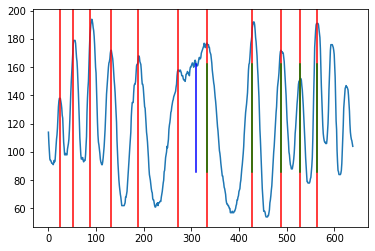

halfMaxims [22, 118, 178, 218, 254]
halfMaxims [13924, 31684, 47524, 64516]


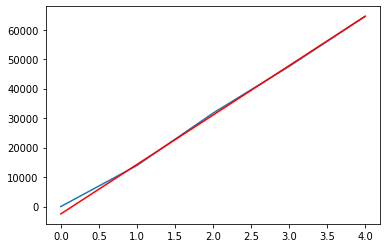

calc 0.8513268423062237 target:  0.785


In [8]:
img = cv2.imread("../data/generated/noised/medianedphoto/00050.png", cv2.IMREAD_GRAYSCALE)
median=cv2.medianBlur(img,21)
mean=0
imgManager=ImageManager("real")#("generatedNoised")
#for i in range (imgManager.__len__()):
#    img,targetEpsilon=imgManager[i]
 #   img=cv2.medianBlur(img,21)
 #   calculatedEpsilon=CalculateEpsilon(img, widthStripesAmount, heightStripesAmount)
 #   print("calc", calculatedEpsilon, "target: ", targetEpsilon, "diff: ", targetEpsilon-calculatedEpsilon)
 #   mean+=abs(targetEpsilon-calculatedEpsilon)
#mean/=imgManager.__len__()
#print(mean)
    
img,targetEpsilon=imgManager[16]
img=cv2.medianBlur(img,21)
print(targetEpsilon)
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()
calculatedEpsilon=CalculateEpsilon(img, widthStripesAmount, heightStripesAmount)
print("calc", calculatedEpsilon, "target: ", targetEpsilon)
